# Exercises XP Gold: W4_D2

### What you will create
- Your own **K-means** clustering function in Python to segment a dataset into groups.  
- **Scatter plots** to visualize data points per cluster and centroid convergence.  
- A **report** with the cluster assignment for each data point.  
- A function to **randomly initialize centroids**.  
- Runs with **different initializations** to compare, evaluate, and refine results.

---

### What you will learn
- The inner workings of the **K-means** algorithm by implementing it from scratch.  
- How to use **Euclidean distance** to compare points and centroids.  
- The impact of **initial centroid selection** and common initialization methods.  
- How K-means iteratively **refines centroids** to minimize within-cluster variance.  
- How to **visualize and interpret** clusters and centroids.

---

### Dataset
Use **`ex7data2.mat`** (MATLAB `.mat` file with unlabeled points). Load it via `scipy.io.loadmat`.

---

### Tasks

### 1) Understanding the Dataset
- Load the dataset with `scipy.io.loadmat`.
- Visualize the data points with a scatter plot.

### 2) Finding Closest Centroids
- Implement **`find_closest_centroids`** to assign each point to its nearest centroid (Euclidean distance).
- Test with initial centroids: `np.array([[3, 3], [6, 2], [8, 5]])` and print the closest centroid index for the **first three** data points.

### 3) Computing Centroids
- Implement **`compute_centroids`** to move each centroid to the mean of its assigned points.
- Test and print new centroid locations.

### 4) Running K-means
- Implement **`run_k_means`** to iterate assignment ↔ centroid update for `max_iters` iterations.
- Run for **10 iterations** and plot clusters (different colors) + final centroid locations.
- Show centroid **paths** across iterations (optional but recommended).

### 5) Initializing Centroids
- Implement **`init_centroids`** to pick random data points as initial centroids.
- Initialize for **K = 3** and print them.

### 6) (Bonus) Multiple Initializations & Best Result
- Run K-means with **several random initializations**.  
- Select the **best** result using **within-cluster sum of squares (WCSS)**.
- Visualize the best clustering and centroid paths.


### Step 1 — Load the ex7data2.mat dataset

Keys in MAT file: ['X']
Shape of X: (300, 2)


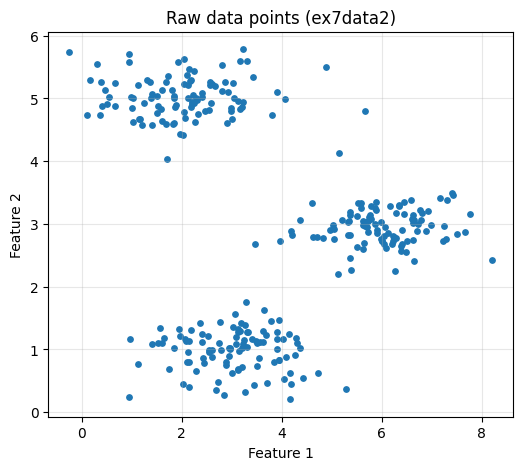

In [2]:
# Step 0 — Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from typing import Tuple

# Step 1 — Load the ex7data2.mat dataset
# Change the path if your file is elsewhere (e.g., "./data/ex7data2.mat")
mat = loadmat("ex7data2.mat")

# Inspect available keys if needed
print("Keys in MAT file:", [k for k in mat.keys() if not k.startswith("__")])

# Extract X (n_samples x 2). In this dataset, points are stored under the key 'X'
if "X" not in mat:
    raise KeyError("Could not find key 'X' in the .mat file. Available keys: "
                   + ", ".join([k for k in mat.keys() if not k.startswith('__')]))
X = mat["X"]
print("Shape of X:", X.shape)

# Step 2 — Quick scatter to visualize points
plt.figure(figsize=(6,5))
plt.scatter(X[:, 0], X[:, 1], s=15)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Raw data points (ex7data2)")
plt.grid(True, alpha=0.3)
plt.show()

### Step 3 — find_closest_centroids (Euclidean)

In [3]:
# Step 3 — Assign each point to the nearest centroid (Euclidean distance)

def find_closest_centroids(X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    For each row in X, compute the index (0..K-1) of the nearest centroid.
    Uses squared Euclidean distance (no need to take sqrt for argmin).
    X: (n_samples, n_features)
    centroids: (K, n_features)
    Returns: idx (n_samples,) with cluster assignment for each point.
    """
    # Expand dims and broadcast: (n,1,d) - (1,K,d) -> (n,K,d)
    diff = X[:, None, :] - centroids[None, :, :]
    dists = np.sum(diff**2, axis=2)  # (n, K)
    idx = np.argmin(dists, axis=1)   # (n,)
    return idx

# Test with provided initial centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]], dtype=float)
idx_test = find_closest_centroids(X, initial_centroids)

print("Closest centroid indices for the first three points:", idx_test[:3].tolist())

Closest centroid indices for the first three points: [0, 2, 1]


### Step 4 - compute_centroids (means per cluster)

In [4]:
# Step 4 — Move centroids to the mean of assigned points

def compute_centroids(X: np.ndarray, idx: np.ndarray, K: int) -> np.ndarray:
    """
    Compute new centroid positions as the mean of points assigned to each cluster.
    If a cluster has no points, reinitialize its centroid to a random data point.
    """
    n_features = X.shape[1]
    new_centroids = np.zeros((K, n_features), dtype=float)

    for k in range(K):
        mask = (idx == k)
        if np.any(mask):
            new_centroids[k] = X[mask].mean(axis=0)
        else:
            # Handle empty cluster by re-seeding with a random existing point
            new_centroids[k] = X[np.random.randint(0, X.shape[0])]
    return new_centroids

# Quick test: compute new centroids after initial assignment
K = initial_centroids.shape[0]
new_c = compute_centroids(X, idx_test, K)
print("New centroid locations after one update:\n", new_c)

New centroid locations after one update:
 [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


### Step 5 - run_k_means (iterate assignments ↔ centroids)

In [5]:
# Step 5 — Full K-means loop

def run_k_means(
    X: np.ndarray,
    initial_centroids: np.ndarray,
    max_iters: int = 10,
    verbose: bool = True
) -> Tuple[np.ndarray, np.ndarray, list]:
    """
    Run K-means for a fixed number of iterations.
    Returns:
      - centroids: final (K, d)
      - idx: final assignments (n,)
      - history: list of centroid arrays over iterations (length = max_iters + 1)
    """
    centroids = initial_centroids.astype(float).copy()
    history = [centroids.copy()]

    for it in range(1, max_iters + 1):
        # 1) Assign to closest centroids
        idx = find_closest_centroids(X, centroids)
        # 2) Recompute centroids
        centroids = compute_centroids(X, idx, centroids.shape[0])
        history.append(centroids.copy())

        if verbose:
            print(f"[Iter {it:02d}] Updated centroids:\n{centroids}\n")

    return centroids, idx, history

### Step 6 - init_centroids (random from data) + run + plots

Randomly initialized centroids:
 [[5.78769095 3.29255127]
 [3.2645514  1.3836869 ]
 [6.17443157 3.29026488]]
[Iter 01] Updated centroids:
[[4.5017768  3.8336222 ]
 [2.42823867 2.62942465]
 [6.64462664 2.93295983]]

[Iter 02] Updated centroids:
[[3.86642759 4.28182764]
 [2.38654444 2.65736262]
 [6.27981833 2.87585895]]

[Iter 03] Updated centroids:
[[2.6591984  4.95079107]
 [2.5066113  1.9713135 ]
 [6.10861578 2.88956956]]

[Iter 04] Updated centroids:
[[1.98363152 5.03043004]
 [3.0442297  1.0574023 ]
 [6.07528056 2.95107375]]

[Iter 05] Updated centroids:
[[1.95399466 5.02557006]
 [3.04367119 1.01541041]
 [6.03366736 3.00052511]]

[Iter 06] Updated centroids:
[[1.95399466 5.02557006]
 [3.04367119 1.01541041]
 [6.03366736 3.00052511]]

[Iter 07] Updated centroids:
[[1.95399466 5.02557006]
 [3.04367119 1.01541041]
 [6.03366736 3.00052511]]

[Iter 08] Updated centroids:
[[1.95399466 5.02557006]
 [3.04367119 1.01541041]
 [6.03366736 3.00052511]]

[Iter 09] Updated centroids:
[[1.95399466 5

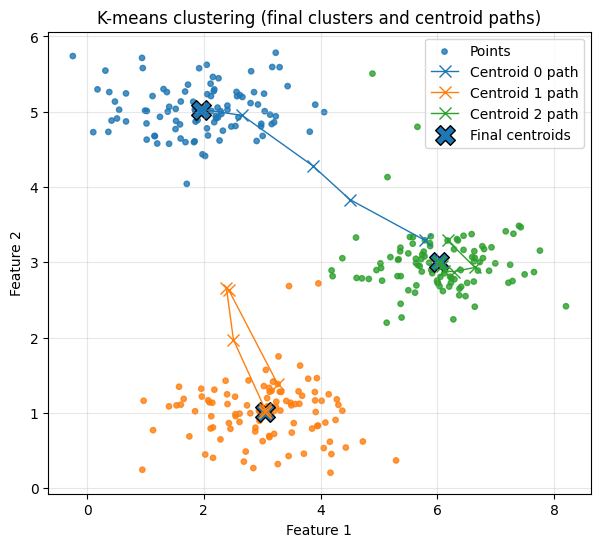

In [6]:
# Step 6 — Random centroid initialization from existing points

def init_centroids(X: np.ndarray, K: int, random_state: int = 42) -> np.ndarray:
    """
    Initialize K centroids by randomly sampling K unique points from X.
    """
    rng = np.random.default_rng(random_state)
    indices = rng.choice(X.shape[0], size=K, replace=False)
    return X[indices].astype(float)

# Test init function
K = 3
rand_c = init_centroids(X, K, random_state=7)
print("Randomly initialized centroids:\n", rand_c)

# Run K-means with 10 iterations
final_c, final_idx, c_history = run_k_means(X, rand_c, max_iters=10, verbose=True)

# Plot final clustering + centroid paths
colors = np.array(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"])
cluster_colors = colors[final_idx % len(colors)]

plt.figure(figsize=(7,6))
plt.scatter(X[:, 0], X[:, 1], c=cluster_colors, s=15, alpha=0.8, label="Points")

# Plot centroid movement across iterations
c_history_arr = np.array(c_history)  # shape: (iters+1, K, d)
for k in range(K):
    path = c_history_arr[:, k, :]
    plt.plot(path[:, 0], path[:, 1], marker='x', linewidth=1, markersize=8, label=f"Centroid {k} path")

# Plot final centroids
plt.scatter(final_c[:, 0], final_c[:, 1], marker='X', s=200, edgecolor='k', linewidth=1.0, label="Final centroids")
plt.title("K-means clustering (final clusters and centroid paths)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Notes & Interpretation

### 1) Understanding the dataset
- The `.mat` file is a MATLAB format. We load it using `scipy.io.loadmat`.
- The points are provided under the key **`X`** (shape typically `(n_samples, 2)`), which we visualize via a scatter plot.

### 2) K-means steps recap
1. **Initialization** — Choose initial centroids (here we implemented `init_centroids` to pick random points from `X`).
2. **Assignment** — For each point, assign it to the closest centroid using **squared Euclidean distance** (no need to take the square root for comparisons).
3. **Update** — Recompute each centroid as the **mean** of the points assigned to it.
4. **Repeat** — Iterate Assignment ↔ Update until convergence or max iterations.

### 3) Functions implemented
- `find_closest_centroids(X, centroids)` — returns the cluster index for each point.
- `compute_centroids(X, idx, K)` — returns updated centroid positions (means of assigned points). If a cluster is empty, we re-seed its centroid with a random point to avoid NaNs.
- `run_k_means(X, initial_centroids, max_iters)` — orchestrates the loop and stores a **history** of centroids to plot the **convergence paths**.
- `init_centroids(X, K, random_state)` — random initialization by sampling existing points.

### 4) Testing & visualization
- We tested `find_closest_centroids` using the provided initial centroids `[[3,3], [6,2], [8,5]]` and printed the closest centroid for the first three points.
- We plotted:
  - The final clustering (points colored by their assigned cluster).
  - The **trajectory** of each centroid across iterations for convergence visualization.

### 5) Initialization matters
- Different initial centroids can lead to **different local minima** (different final clusters).
- Try running multiple times with different `random_state` values or initial seeds, then compare the results.

### 6) Tips for refinement (optional)
- Add a **convergence criterion** (stop when centroid movement is below a tolerance).
- Run multiple initializations and pick the result with the lowest **within-cluster sum of squares (WCSS)**.
- Explore **k-means++** initialization to improve consistency of results.

### Bonus — Multiple initializations (select best by WCSS)

[Init 01/8] WCSS = 266.66
[Init 02/8] WCSS = 266.66
[Init 03/8] WCSS = 266.66
[Init 04/8] WCSS = 266.66
[Init 05/8] WCSS = 266.66
[Init 06/8] WCSS = 266.66
[Init 07/8] WCSS = 266.66
[Init 08/8] WCSS = 266.66

 Best WCSS = 266.66
Best initial centroids:
 [[3.54010186 0.86446135]
 [5.63325403 2.99002339]
 [3.23197916 4.93989405]]
Final centroids:
 [[3.04367119 1.01541041]
 [6.03366736 3.00052511]
 [1.95399466 5.02557006]]


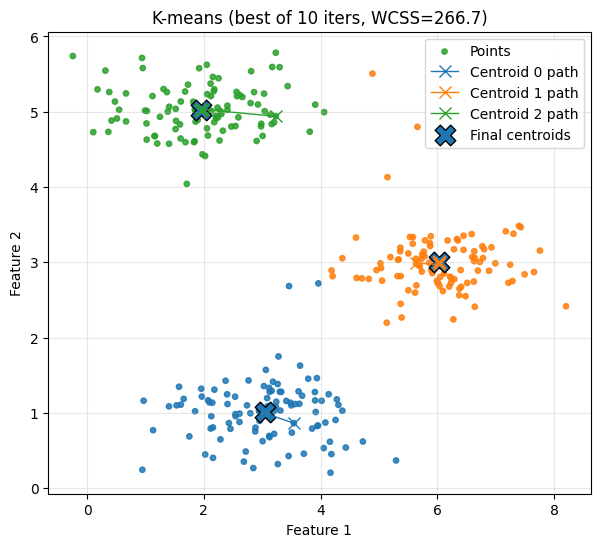

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Helper: WCSS (Within-Cluster Sum of Squares) ---
def wcss_inertia(X: np.ndarray, centroids: np.ndarray, idx: np.ndarray) -> float:
    """
    Compute within-cluster sum of squares for given assignments and centroids.
    """
    total = 0.0
    for k in range(centroids.shape[0]):
        cluster = X[idx == k]
        if cluster.size:
            diffs = cluster - centroids[k]
            total += float(np.sum(diffs ** 2))
    return total

# --- Multi-start K-means ---
def kmeans_multi_init(
    X: np.ndarray,
    K: int,
    n_init: int = 10,
    max_iters: int = 10,
    random_state: int = 42,
    verbose: bool = True
):
    """
    Run K-means with multiple random initializations and keep the best (lowest WCSS).
    Requires the functions defined earlier:
      - init_centroids(X, K, random_state)
      - run_k_means(X, initial_centroids, max_iters, verbose=False)
    Returns:
      final_c, final_idx, best_history, best_wcss, best_init
    """
    best_wcss = np.inf
    best_tuple = None
    best_history = None
    best_init = None

    for i in range(n_init):
        seed = random_state + i
        init_c = init_centroids(X, K, random_state=seed)
        c, idx, history = run_k_means(X, init_c, max_iters=max_iters, verbose=False)
        wcss = wcss_inertia(X, c, idx)
        if verbose:
            print(f"[Init {i+1:02d}/{n_init}] WCSS = {wcss:.2f}")

        if wcss < best_wcss:
            best_wcss = wcss
            best_tuple = (c, idx)
            best_history = history
            best_init = init_c

    final_c, final_idx = best_tuple
    if verbose:
        print(f"\n Best WCSS = {best_wcss:.2f}")
        print("Best initial centroids:\n", best_init)
        print("Final centroids:\n", final_c)
    return final_c, final_idx, best_history, best_wcss, best_init

# --- Run multi-init K-means (adjust n_init if you want) ---
K = 3
final_c_best, final_idx_best, history_best, best_wcss, best_init = kmeans_multi_init(
    X, K, n_init=8, max_iters=10, random_state=123, verbose=True
)

# --- Plot best result with centroid paths ---
colors = np.array([
    "tab:blue", "tab:orange", "tab:green", "tab:red",
    "tab:purple", "tab:brown", "tab:pink", "tab:gray"
])
cluster_colors = colors[final_idx_best % len(colors)]

plt.figure(figsize=(7,6))
plt.scatter(X[:, 0], X[:, 1], c=cluster_colors, s=15, alpha=0.85, label="Points")

# Plot centroid movement across iterations
c_hist = np.array(history_best)  # shape: (iters+1, K, 2)
for k in range(K):
    path = c_hist[:, k, :]
    plt.plot(path[:, 0], path[:, 1], marker='x', linewidth=1.0, markersize=8, label=f"Centroid {k} path")

# Final centroids
plt.scatter(final_c_best[:, 0], final_c_best[:, 1], marker='X', s=220, edgecolor='k', linewidth=1.0, label="Final centroids")

plt.title(f"K-means (best of {len(history_best)-1} iters, WCSS={best_wcss:.1f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Conclusions — K-means from Scratch

**What we implemented**
- A complete K-means pipeline: `init_centroids`, `find_closest_centroids`, `compute_centroids`, and `run_k_means`.
- Robust handling for edge cases (e.g., empty clusters → re-seed with a random point).
- Visual diagnostics: final cluster assignment, centroid paths across iterations.
- A multi-initialization routine selecting the **best run** via **WCSS (Within-Cluster Sum of Squares)**.

**What we observed**
- **Initialization matters**: different seeds can converge to different local minima and cluster shapes.
- **WCSS** is a practical objective to compare runs; lower WCSS indicates tighter, more coherent clusters.
- **Convergence** is visible as centroid paths shorten and stabilize; iterations beyond convergence add little value.

**How to evaluate & refine**
- Use **multiple initializations** (or **k-means++**) to reduce sensitivity to starting points.
- Inspect **WCSS** across different **K** and consider an **Elbow plot** to choose K.
- Complement WCSS with **Silhouette Score** or **Davies–Bouldin Index** to assess separation vs compactness.
- Standardize features when scales differ; otherwise, distance can be dominated by high-variance dimensions.

**Practical takeaways**
- K-means is fast and effective when clusters are roughly spherical and similar in size.
- Results are **not deterministic**—always run multiple inits and validate with quantitative metrics **and** plots.
- For non-spherical or uneven-density data, consider alternatives (e.g., **Gaussian Mixture Models**, **DBSCAN**, **Spectral Clustering**).

**Next steps (optional)**
- Add a **tolerance-based stopping** criterion (stop when centroid shift < ε).
- Implement **k-means++** initialization for more stable solutions.
- Automate **Elbow** and **Silhouette** plots to guide K selection.